# **Roadmap:**
### - [Setup](#Environment-setup-for-Kubeless-functions-and-Q-learning)
### - [Training algorithm](#Train-the-agent)
### - [Result plots](#Analyze-results)

# Environment setup for Kubeless functions and Q learning

## Install the gym-k8s package that registers our environments

In [1]:
!pip3 install -e ../../gym-k8s
!pip3 install matplotlib pandas seaborn

Obtaining file:///home/nick/k8s-rl-autoscaler/gym-k8s
  Attempting uninstall: gym-k8s
    Found existing installation: gym-k8s 0.0.2
    Uninstalling gym-k8s-0.0.2:
      Successfully uninstalled gym-k8s-0.0.2
  Running setup.py develop for gym-k8s
You should consider upgrading via the '/home/nick/python-venv/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nick/python-venv/env/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import json
import random
import time
import uuid
import numpy as np

from gym_k8s.envs import K8sEnvDiscreteStateDiscreteActionV5

## Info of the Kubeless app we want to deploy

In [3]:
# Timestep duration in minutes
# We wait these many minutes for our actions to be enforced
timestep_duration = 6
app_name = 'fibonacci'
input_file = '~/serverless-elasticity-management/examples/kubeless/fibonacci-python/app.py'
handler_fun = 'app.fibonacci'
memory_req = '128Mi'
cpu_req = '80m'
sla_latency = 0.25
prometheus_host = 'http://localhost:9090/'
# Nginx ingress latency metric
prometheus_latency_metric_name = '(sum(rate(nginx_ingress_controller_request_duration_seconds_sum'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'\
    '/(sum(rate(nginx_ingress_controller_request_duration_seconds_count'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'.format(app_name, timestep_duration)
q_table_file = 'Q-kubeless-env-discrete-state-discrete-action-V5-data.npy'
q_table_init_value = 50
total_epochs = 8000
steps_per_epoch = 16
eval_interval = 10
eval_epochs = 3

## Subclass our environment to provide simulated metrics

In [4]:
class SimulatedEnv(K8sEnvDiscreteStateDiscreteActionV5):
    def __init__(self,
                 timestep_duration,
                 app_name,
                 sla_latency,
                 prometheus_host,
                 prometheus_latency_metric_name,
                 input_file,
                 handler_fun,
                 memory_req,
                 cpu_req,
                 max_episode_steps,
                 cpu_thresh_init):

        with open('../kubeless-env-discrete-state-discrete-action-V5/old-outputs/06/distributions.json') as f:
            self.distributions = json.load(f)
        
        self.cpu_thresh_init = cpu_thresh_init
        self.cpu_min_thresh = 20
        self.cpu_max_thresh = 100
        self.threshold_step = 20
        self.possible_thresholds = list(
                range(self.cpu_min_thresh, self.cpu_max_thresh + 1, self.threshold_step)
        )
        self.steps = 0
        self.max_episode_steps = max_episode_steps
        self.timestep_duration = timestep_duration
        self.input_file = input_file
        self.handler_fun = handler_fun
        self.memory_req = memory_req
        self.cpu_req = cpu_req
        service_id = uuid.uuid4()
        self.current_app_name = '{}{}'.format(app_name, service_id)
        self.endpoint = 'kubeless-{}-python.default.127.0.0.1.nip.io:8000'.format(self.current_app_name)

        current_latency_metric_name = prometheus_latency_metric_name.replace(app_name, self.current_app_name)

        super().__init__(
            timestep_duration=timestep_duration,
            app_name=self.current_app_name,
            sla_latency=sla_latency,
            prometheus_host=prometheus_host,
            prometheus_latency_metric_name=current_latency_metric_name,
            cpu_thresh_init=cpu_thresh_init
        )

    def step(self, action):
        base_rate = 0.5
        stress_timesteps_dict = {
            base_rate: {0, 1},
            3 * base_rate: {2, 3, 14, 15},
            5 * base_rate: {4, 5, 12, 13},
            7 * base_rate: {6, 7, 10, 11},
            9 * base_rate: {8, 9}
        }
        
        # Loop through dictionary and find the current stress rate
        for stress_rate in stress_timesteps_dict:
            if self.steps in stress_timesteps_dict[stress_rate]:
                self.current_stress = str(stress_rate)

        if action == 0 and self.current_cpu_thresh > self.cpu_min_thresh:
            self.current_cpu_thresh -= self.threshold_step

        if action == 2 and self.current_cpu_thresh < self.cpu_max_thresh:
            self.current_cpu_thresh += self.threshold_step

        (pod_cpu_current_util,
         current_replicas,
         latency) = self._simulate_metrics()

        pod_cpu_threshold = self.current_cpu_thresh

        observation = [
            pod_cpu_current_util,
            pod_cpu_threshold,
            current_replicas,
            latency
        ]
        reward = self._get_reward(observation)

        self.steps += 1
        if self.steps % self.max_episode_steps == 0:
            self.steps = 0

        encoded_observation = self._encode_observation(observation)
        info = ''
        return encoded_observation, observation, reward, self.done, info

    def reset(self):
        self.steps = 0

        if self.cpu_thresh_init is not None:
            self.current_cpu_thresh = self.cpu_thresh_init
        else:
            self.current_cpu_thresh = random.choice(self.possible_thresholds)

        pod_cpu_current_util = 0
        pod_cpu_threshold = 20
        current_replicas = self.MAX_PODS
        latency = 100 * self.sla_latency

        init_observation = [
            pod_cpu_current_util,
            pod_cpu_threshold,
            current_replicas,
            latency
        ]
        
        encoded_observation = self._encode_observation(init_observation)

        info = ''
        return encoded_observation, init_observation

    def _simulate_metrics(self):
        replicas_mean = float(self.distributions[self.current_stress]['thresh'][str(self.current_cpu_thresh)]['replicas_mean'])
        replicas_std = float(self.distributions[self.current_stress]['thresh'][str(self.current_cpu_thresh)]['replicas_std'])
        current_replicas = round(random.gauss(replicas_mean, replicas_std))
        
        cpu_util_mean = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['cpu_util_mean'])
        cpu_util_std = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['cpu_util_std'])
        pod_cpu_current_util = random.gauss(cpu_util_mean, cpu_util_std)
        
        latency_mean = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['latency_mean'])
        latency_std = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['latency_std'])
        latency = random.gauss(latency_mean, latency_std)

        simulated_metrics = [
            pod_cpu_current_util,
            current_replicas,
            latency
        ]
        return simulated_metrics
    
    def _encode_observation(self, observation):
        (pod_cpu_current_util,
         pod_cpu_threshold,
         current_replicas,
         latency) = observation
        
        if pod_cpu_threshold != 0:
            pod_cpu_percent = 100 * pod_cpu_current_util / pod_cpu_threshold
        else:
            pod_cpu_percent = 200
        current_replicas_percent = 100 * current_replicas / self.MAX_PODS
        pod_latency_percent = 100 * latency / self.sla_latency

        real_observation_percent = [
            pod_cpu_percent,
            current_replicas_percent,
            pod_latency_percent
        ]

        discretized_observation = [self._get_discrete(ob) for ob in real_observation_percent]
        encoded_observation = self.encode(
            discretized_observation[0],
            discretized_observation[1],
            discretized_observation[2]
        )
        
        return encoded_observation

## Load or create the Q table
If our Q table file is present, we load in into memory. Otherwise we create a gym environment and using the environment's observation and space dimensions, we create a new one.

In [5]:
try:
    q_table = np.load(q_table_file)

    print('File present. Loading done!')
except IOError:
    cpu_thresh_init = None
    env = SimulatedEnv(
        timestep_duration,
        app_name,
        sla_latency,
        prometheus_host,
        prometheus_latency_metric_name,
        input_file,
        handler_fun,
        memory_req,
        cpu_req,
        steps_per_epoch,
        cpu_thresh_init
    )

    q_table = np.full((env.observation_space.n, env.action_space.n), q_table_init_value)
    np.save(q_table_file, q_table)

    print('File not present. Created successfully!')

File present. Loading done!


## Create historical states csv file if it doesn't exist

In [6]:
try:
    open('k8s_historical_states_discrete.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('k8s_historical_states_discrete.csv', 'w') as f:
        f.write('current_app_name,timestep,state,action,next_state,reward,'
                'done,number_of_pods,cpu_util,latency_violation,latency,hpa_threshold,info\n')
    print('File not present. Created successfully!')

File already present.


# Train the agent

## Evaluation

In [7]:
def evaluation(current_eval_epoch):
    possible_thresholds = list(range(20, 101, 20))

    for threshold in possible_thresholds:
        eval_env = SimulatedEnv(
            timestep_duration,
            app_name,
            sla_latency,
            prometheus_host,
            prometheus_latency_metric_name,
            input_file,
            handler_fun,
            memory_req,
            cpu_req,
            steps_per_epoch,
            threshold
        )

        state, _ = eval_env.reset()

        for epoch in range(eval_epochs):
            for step in range(steps_per_epoch):
                action = np.argmax(q_table[state]) 
                next_state, real_ob, reward, done, info = eval_env.step(action)

                (pod_cpu_util,
                 cpu_threshold,
                 number_of_pods,
                 latency) = real_ob

                # Latency violation becomes 1 if the SLA was violated
                # otherwise it's 0
                latency_violation = int(latency > sla_latency)

                # Save historical tuple
                current_timestep = (current_eval_epoch * eval_epochs + epoch) * steps_per_epoch + step
                with open('k8s_historical_states_discrete.csv', 'a') as f:
                    f.write(
                        '{},{},{},{},'.format(app_name, current_timestep, state, action) +
                        '{},{},{},{},'.format(next_state, reward, done, number_of_pods) +
                        '{},{},{},{},{}'.format(pod_cpu_util, latency_violation, latency, cpu_threshold, info) +
                        '\n'
                    )

                state = next_state

## Agent training
This function trains our agent:

In [8]:
# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon_init = 0.97
epsilon_min = 0.2

cpu_thresh_init = None
train_env = SimulatedEnv(
    timestep_duration,
    app_name,
    sla_latency,
    prometheus_host,
    prometheus_latency_metric_name,
    input_file,
    handler_fun,
    memory_req,
    cpu_req,
    steps_per_epoch,
    cpu_thresh_init
)

state, _ = train_env.reset()

for epoch in range(total_epochs):
    print('Epoch: {}'.format(epoch))

    done = False

    for step in range(steps_per_epoch):
        current_timestep = epoch * steps_per_epoch + step

        max_decay_steps = 10000
        current_timestep = min(current_timestep, max_decay_steps)
        epsilon = (epsilon_init - epsilon_min) *\
            (1 - current_timestep / max_decay_steps) ** (0.5) +  epsilon_min

        if not done:    
            if random.uniform(0, 1) < epsilon:
                action = train_env.action_space.sample()  # Explore action space, non-greedy (NG) action selection
            else:
                action = np.argmax(q_table[state])  # Exploit learned values, greedy (G) action selection

            next_state, real_ob, reward, done, info = train_env.step(action)

            old_value = q_table[state, action]
            # Q-table update is always greedy (np.max)
            # Q-learning is off-policy since the action taken can be of a different policy (non-greedy, random) (NG)
            next_max = np.max(q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state
    
    np.save(q_table_file, q_table)
    
    if epoch % eval_interval == 0:
        evaluation(epoch // eval_interval)
        state, _ = train_env.reset()

print('Training finished.')

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

Epoch: 771
Epoch: 772
Epoch: 773
Epoch: 774
Epoch: 775
Epoch: 776
Epoch: 777
Epoch: 778
Epoch: 779
Epoch: 780
Epoch: 781
Epoch: 782
Epoch: 783
Epoch: 784
Epoch: 785
Epoch: 786
Epoch: 787
Epoch: 788
Epoch: 789
Epoch: 790
Epoch: 791
Epoch: 792
Epoch: 793
Epoch: 794
Epoch: 795
Epoch: 796
Epoch: 797
Epoch: 798
Epoch: 799
Epoch: 800
Epoch: 801
Epoch: 802
Epoch: 803
Epoch: 804
Epoch: 805
Epoch: 806
Epoch: 807
Epoch: 808
Epoch: 809
Epoch: 810
Epoch: 811
Epoch: 812
Epoch: 813
Epoch: 814
Epoch: 815
Epoch: 816
Epoch: 817
Epoch: 818
Epoch: 819
Epoch: 820
Epoch: 821
Epoch: 822
Epoch: 823
Epoch: 824
Epoch: 825
Epoch: 826
Epoch: 827
Epoch: 828
Epoch: 829
Epoch: 830
Epoch: 831
Epoch: 832
Epoch: 833
Epoch: 834
Epoch: 835
Epoch: 836
Epoch: 837
Epoch: 838
Epoch: 839
Epoch: 840
Epoch: 841
Epoch: 842
Epoch: 843
Epoch: 844
Epoch: 845
Epoch: 846
Epoch: 847
Epoch: 848
Epoch: 849
Epoch: 850
Epoch: 851
Epoch: 852
Epoch: 853
Epoch: 854
Epoch: 855
Epoch: 856
Epoch: 857
Epoch: 858
Epoch: 859
Epoch: 860
Epoch: 861

Epoch: 1491
Epoch: 1492
Epoch: 1493
Epoch: 1494
Epoch: 1495
Epoch: 1496
Epoch: 1497
Epoch: 1498
Epoch: 1499
Epoch: 1500
Epoch: 1501
Epoch: 1502
Epoch: 1503
Epoch: 1504
Epoch: 1505
Epoch: 1506
Epoch: 1507
Epoch: 1508
Epoch: 1509
Epoch: 1510
Epoch: 1511
Epoch: 1512
Epoch: 1513
Epoch: 1514
Epoch: 1515
Epoch: 1516
Epoch: 1517
Epoch: 1518
Epoch: 1519
Epoch: 1520
Epoch: 1521
Epoch: 1522
Epoch: 1523
Epoch: 1524
Epoch: 1525
Epoch: 1526
Epoch: 1527
Epoch: 1528
Epoch: 1529
Epoch: 1530
Epoch: 1531
Epoch: 1532
Epoch: 1533
Epoch: 1534
Epoch: 1535
Epoch: 1536
Epoch: 1537
Epoch: 1538
Epoch: 1539
Epoch: 1540
Epoch: 1541
Epoch: 1542
Epoch: 1543
Epoch: 1544
Epoch: 1545
Epoch: 1546
Epoch: 1547
Epoch: 1548
Epoch: 1549
Epoch: 1550
Epoch: 1551
Epoch: 1552
Epoch: 1553
Epoch: 1554
Epoch: 1555
Epoch: 1556
Epoch: 1557
Epoch: 1558
Epoch: 1559
Epoch: 1560
Epoch: 1561
Epoch: 1562
Epoch: 1563
Epoch: 1564
Epoch: 1565
Epoch: 1566
Epoch: 1567
Epoch: 1568
Epoch: 1569
Epoch: 1570
Epoch: 1571
Epoch: 1572
Epoch: 1573
Epoc

Epoch: 2191
Epoch: 2192
Epoch: 2193
Epoch: 2194
Epoch: 2195
Epoch: 2196
Epoch: 2197
Epoch: 2198
Epoch: 2199
Epoch: 2200
Epoch: 2201
Epoch: 2202
Epoch: 2203
Epoch: 2204
Epoch: 2205
Epoch: 2206
Epoch: 2207
Epoch: 2208
Epoch: 2209
Epoch: 2210
Epoch: 2211
Epoch: 2212
Epoch: 2213
Epoch: 2214
Epoch: 2215
Epoch: 2216
Epoch: 2217
Epoch: 2218
Epoch: 2219
Epoch: 2220
Epoch: 2221
Epoch: 2222
Epoch: 2223
Epoch: 2224
Epoch: 2225
Epoch: 2226
Epoch: 2227
Epoch: 2228
Epoch: 2229
Epoch: 2230
Epoch: 2231
Epoch: 2232
Epoch: 2233
Epoch: 2234
Epoch: 2235
Epoch: 2236
Epoch: 2237
Epoch: 2238
Epoch: 2239
Epoch: 2240
Epoch: 2241
Epoch: 2242
Epoch: 2243
Epoch: 2244
Epoch: 2245
Epoch: 2246
Epoch: 2247
Epoch: 2248
Epoch: 2249
Epoch: 2250
Epoch: 2251
Epoch: 2252
Epoch: 2253
Epoch: 2254
Epoch: 2255
Epoch: 2256
Epoch: 2257
Epoch: 2258
Epoch: 2259
Epoch: 2260
Epoch: 2261
Epoch: 2262
Epoch: 2263
Epoch: 2264
Epoch: 2265
Epoch: 2266
Epoch: 2267
Epoch: 2268
Epoch: 2269
Epoch: 2270
Epoch: 2271
Epoch: 2272
Epoch: 2273
Epoc

Epoch: 2901
Epoch: 2902
Epoch: 2903
Epoch: 2904
Epoch: 2905
Epoch: 2906
Epoch: 2907
Epoch: 2908
Epoch: 2909
Epoch: 2910
Epoch: 2911
Epoch: 2912
Epoch: 2913
Epoch: 2914
Epoch: 2915
Epoch: 2916
Epoch: 2917
Epoch: 2918
Epoch: 2919
Epoch: 2920
Epoch: 2921
Epoch: 2922
Epoch: 2923
Epoch: 2924
Epoch: 2925
Epoch: 2926
Epoch: 2927
Epoch: 2928
Epoch: 2929
Epoch: 2930
Epoch: 2931
Epoch: 2932
Epoch: 2933
Epoch: 2934
Epoch: 2935
Epoch: 2936
Epoch: 2937
Epoch: 2938
Epoch: 2939
Epoch: 2940
Epoch: 2941
Epoch: 2942
Epoch: 2943
Epoch: 2944
Epoch: 2945
Epoch: 2946
Epoch: 2947
Epoch: 2948
Epoch: 2949
Epoch: 2950
Epoch: 2951
Epoch: 2952
Epoch: 2953
Epoch: 2954
Epoch: 2955
Epoch: 2956
Epoch: 2957
Epoch: 2958
Epoch: 2959
Epoch: 2960
Epoch: 2961
Epoch: 2962
Epoch: 2963
Epoch: 2964
Epoch: 2965
Epoch: 2966
Epoch: 2967
Epoch: 2968
Epoch: 2969
Epoch: 2970
Epoch: 2971
Epoch: 2972
Epoch: 2973
Epoch: 2974
Epoch: 2975
Epoch: 2976
Epoch: 2977
Epoch: 2978
Epoch: 2979
Epoch: 2980
Epoch: 2981
Epoch: 2982
Epoch: 2983
Epoc

Epoch: 3591
Epoch: 3592
Epoch: 3593
Epoch: 3594
Epoch: 3595
Epoch: 3596
Epoch: 3597
Epoch: 3598
Epoch: 3599
Epoch: 3600
Epoch: 3601
Epoch: 3602
Epoch: 3603
Epoch: 3604
Epoch: 3605
Epoch: 3606
Epoch: 3607
Epoch: 3608
Epoch: 3609
Epoch: 3610
Epoch: 3611
Epoch: 3612
Epoch: 3613
Epoch: 3614
Epoch: 3615
Epoch: 3616
Epoch: 3617
Epoch: 3618
Epoch: 3619
Epoch: 3620
Epoch: 3621
Epoch: 3622
Epoch: 3623
Epoch: 3624
Epoch: 3625
Epoch: 3626
Epoch: 3627
Epoch: 3628
Epoch: 3629
Epoch: 3630
Epoch: 3631
Epoch: 3632
Epoch: 3633
Epoch: 3634
Epoch: 3635
Epoch: 3636
Epoch: 3637
Epoch: 3638
Epoch: 3639
Epoch: 3640
Epoch: 3641
Epoch: 3642
Epoch: 3643
Epoch: 3644
Epoch: 3645
Epoch: 3646
Epoch: 3647
Epoch: 3648
Epoch: 3649
Epoch: 3650
Epoch: 3651
Epoch: 3652
Epoch: 3653
Epoch: 3654
Epoch: 3655
Epoch: 3656
Epoch: 3657
Epoch: 3658
Epoch: 3659
Epoch: 3660
Epoch: 3661
Epoch: 3662
Epoch: 3663
Epoch: 3664
Epoch: 3665
Epoch: 3666
Epoch: 3667
Epoch: 3668
Epoch: 3669
Epoch: 3670
Epoch: 3671
Epoch: 3672
Epoch: 3673
Epoc

Epoch: 4301
Epoch: 4302
Epoch: 4303
Epoch: 4304
Epoch: 4305
Epoch: 4306
Epoch: 4307
Epoch: 4308
Epoch: 4309
Epoch: 4310
Epoch: 4311
Epoch: 4312
Epoch: 4313
Epoch: 4314
Epoch: 4315
Epoch: 4316
Epoch: 4317
Epoch: 4318
Epoch: 4319
Epoch: 4320
Epoch: 4321
Epoch: 4322
Epoch: 4323
Epoch: 4324
Epoch: 4325
Epoch: 4326
Epoch: 4327
Epoch: 4328
Epoch: 4329
Epoch: 4330
Epoch: 4331
Epoch: 4332
Epoch: 4333
Epoch: 4334
Epoch: 4335
Epoch: 4336
Epoch: 4337
Epoch: 4338
Epoch: 4339
Epoch: 4340
Epoch: 4341
Epoch: 4342
Epoch: 4343
Epoch: 4344
Epoch: 4345
Epoch: 4346
Epoch: 4347
Epoch: 4348
Epoch: 4349
Epoch: 4350
Epoch: 4351
Epoch: 4352
Epoch: 4353
Epoch: 4354
Epoch: 4355
Epoch: 4356
Epoch: 4357
Epoch: 4358
Epoch: 4359
Epoch: 4360
Epoch: 4361
Epoch: 4362
Epoch: 4363
Epoch: 4364
Epoch: 4365
Epoch: 4366
Epoch: 4367
Epoch: 4368
Epoch: 4369
Epoch: 4370
Epoch: 4371
Epoch: 4372
Epoch: 4373
Epoch: 4374
Epoch: 4375
Epoch: 4376
Epoch: 4377
Epoch: 4378
Epoch: 4379
Epoch: 4380
Epoch: 4381
Epoch: 4382
Epoch: 4383
Epoc

Epoch: 5001
Epoch: 5002
Epoch: 5003
Epoch: 5004
Epoch: 5005
Epoch: 5006
Epoch: 5007
Epoch: 5008
Epoch: 5009
Epoch: 5010
Epoch: 5011
Epoch: 5012
Epoch: 5013
Epoch: 5014
Epoch: 5015
Epoch: 5016
Epoch: 5017
Epoch: 5018
Epoch: 5019
Epoch: 5020
Epoch: 5021
Epoch: 5022
Epoch: 5023
Epoch: 5024
Epoch: 5025
Epoch: 5026
Epoch: 5027
Epoch: 5028
Epoch: 5029
Epoch: 5030
Epoch: 5031
Epoch: 5032
Epoch: 5033
Epoch: 5034
Epoch: 5035
Epoch: 5036
Epoch: 5037
Epoch: 5038
Epoch: 5039
Epoch: 5040
Epoch: 5041
Epoch: 5042
Epoch: 5043
Epoch: 5044
Epoch: 5045
Epoch: 5046
Epoch: 5047
Epoch: 5048
Epoch: 5049
Epoch: 5050
Epoch: 5051
Epoch: 5052
Epoch: 5053
Epoch: 5054
Epoch: 5055
Epoch: 5056
Epoch: 5057
Epoch: 5058
Epoch: 5059
Epoch: 5060
Epoch: 5061
Epoch: 5062
Epoch: 5063
Epoch: 5064
Epoch: 5065
Epoch: 5066
Epoch: 5067
Epoch: 5068
Epoch: 5069
Epoch: 5070
Epoch: 5071
Epoch: 5072
Epoch: 5073
Epoch: 5074
Epoch: 5075
Epoch: 5076
Epoch: 5077
Epoch: 5078
Epoch: 5079
Epoch: 5080
Epoch: 5081
Epoch: 5082
Epoch: 5083
Epoc

Epoch: 5711
Epoch: 5712
Epoch: 5713
Epoch: 5714
Epoch: 5715
Epoch: 5716
Epoch: 5717
Epoch: 5718
Epoch: 5719
Epoch: 5720
Epoch: 5721
Epoch: 5722
Epoch: 5723
Epoch: 5724
Epoch: 5725
Epoch: 5726
Epoch: 5727
Epoch: 5728
Epoch: 5729
Epoch: 5730
Epoch: 5731
Epoch: 5732
Epoch: 5733
Epoch: 5734
Epoch: 5735
Epoch: 5736
Epoch: 5737
Epoch: 5738
Epoch: 5739
Epoch: 5740
Epoch: 5741
Epoch: 5742
Epoch: 5743
Epoch: 5744
Epoch: 5745
Epoch: 5746
Epoch: 5747
Epoch: 5748
Epoch: 5749
Epoch: 5750
Epoch: 5751
Epoch: 5752
Epoch: 5753
Epoch: 5754
Epoch: 5755
Epoch: 5756
Epoch: 5757
Epoch: 5758
Epoch: 5759
Epoch: 5760
Epoch: 5761
Epoch: 5762
Epoch: 5763
Epoch: 5764
Epoch: 5765
Epoch: 5766
Epoch: 5767
Epoch: 5768
Epoch: 5769
Epoch: 5770
Epoch: 5771
Epoch: 5772
Epoch: 5773
Epoch: 5774
Epoch: 5775
Epoch: 5776
Epoch: 5777
Epoch: 5778
Epoch: 5779
Epoch: 5780
Epoch: 5781
Epoch: 5782
Epoch: 5783
Epoch: 5784
Epoch: 5785
Epoch: 5786
Epoch: 5787
Epoch: 5788
Epoch: 5789
Epoch: 5790
Epoch: 5791
Epoch: 5792
Epoch: 5793
Epoc

Epoch: 6411
Epoch: 6412
Epoch: 6413
Epoch: 6414
Epoch: 6415
Epoch: 6416
Epoch: 6417
Epoch: 6418
Epoch: 6419
Epoch: 6420
Epoch: 6421
Epoch: 6422
Epoch: 6423
Epoch: 6424
Epoch: 6425
Epoch: 6426
Epoch: 6427
Epoch: 6428
Epoch: 6429
Epoch: 6430
Epoch: 6431
Epoch: 6432
Epoch: 6433
Epoch: 6434
Epoch: 6435
Epoch: 6436
Epoch: 6437
Epoch: 6438
Epoch: 6439
Epoch: 6440
Epoch: 6441
Epoch: 6442
Epoch: 6443
Epoch: 6444
Epoch: 6445
Epoch: 6446
Epoch: 6447
Epoch: 6448
Epoch: 6449
Epoch: 6450
Epoch: 6451
Epoch: 6452
Epoch: 6453
Epoch: 6454
Epoch: 6455
Epoch: 6456
Epoch: 6457
Epoch: 6458
Epoch: 6459
Epoch: 6460
Epoch: 6461
Epoch: 6462
Epoch: 6463
Epoch: 6464
Epoch: 6465
Epoch: 6466
Epoch: 6467
Epoch: 6468
Epoch: 6469
Epoch: 6470
Epoch: 6471
Epoch: 6472
Epoch: 6473
Epoch: 6474
Epoch: 6475
Epoch: 6476
Epoch: 6477
Epoch: 6478
Epoch: 6479
Epoch: 6480
Epoch: 6481
Epoch: 6482
Epoch: 6483
Epoch: 6484
Epoch: 6485
Epoch: 6486
Epoch: 6487
Epoch: 6488
Epoch: 6489
Epoch: 6490
Epoch: 6491
Epoch: 6492
Epoch: 6493
Epoc

Epoch: 7131
Epoch: 7132
Epoch: 7133
Epoch: 7134
Epoch: 7135
Epoch: 7136
Epoch: 7137
Epoch: 7138
Epoch: 7139
Epoch: 7140
Epoch: 7141
Epoch: 7142
Epoch: 7143
Epoch: 7144
Epoch: 7145
Epoch: 7146
Epoch: 7147
Epoch: 7148
Epoch: 7149
Epoch: 7150
Epoch: 7151
Epoch: 7152
Epoch: 7153
Epoch: 7154
Epoch: 7155
Epoch: 7156
Epoch: 7157
Epoch: 7158
Epoch: 7159
Epoch: 7160
Epoch: 7161
Epoch: 7162
Epoch: 7163
Epoch: 7164
Epoch: 7165
Epoch: 7166
Epoch: 7167
Epoch: 7168
Epoch: 7169
Epoch: 7170
Epoch: 7171
Epoch: 7172
Epoch: 7173
Epoch: 7174
Epoch: 7175
Epoch: 7176
Epoch: 7177
Epoch: 7178
Epoch: 7179
Epoch: 7180
Epoch: 7181
Epoch: 7182
Epoch: 7183
Epoch: 7184
Epoch: 7185
Epoch: 7186
Epoch: 7187
Epoch: 7188
Epoch: 7189
Epoch: 7190
Epoch: 7191
Epoch: 7192
Epoch: 7193
Epoch: 7194
Epoch: 7195
Epoch: 7196
Epoch: 7197
Epoch: 7198
Epoch: 7199
Epoch: 7200
Epoch: 7201
Epoch: 7202
Epoch: 7203
Epoch: 7204
Epoch: 7205
Epoch: 7206
Epoch: 7207
Epoch: 7208
Epoch: 7209
Epoch: 7210
Epoch: 7211
Epoch: 7212
Epoch: 7213
Epoc

Epoch: 7851
Epoch: 7852
Epoch: 7853
Epoch: 7854
Epoch: 7855
Epoch: 7856
Epoch: 7857
Epoch: 7858
Epoch: 7859
Epoch: 7860
Epoch: 7861
Epoch: 7862
Epoch: 7863
Epoch: 7864
Epoch: 7865
Epoch: 7866
Epoch: 7867
Epoch: 7868
Epoch: 7869
Epoch: 7870
Epoch: 7871
Epoch: 7872
Epoch: 7873
Epoch: 7874
Epoch: 7875
Epoch: 7876
Epoch: 7877
Epoch: 7878
Epoch: 7879
Epoch: 7880
Epoch: 7881
Epoch: 7882
Epoch: 7883
Epoch: 7884
Epoch: 7885
Epoch: 7886
Epoch: 7887
Epoch: 7888
Epoch: 7889
Epoch: 7890
Epoch: 7891
Epoch: 7892
Epoch: 7893
Epoch: 7894
Epoch: 7895
Epoch: 7896
Epoch: 7897
Epoch: 7898
Epoch: 7899
Epoch: 7900
Epoch: 7901
Epoch: 7902
Epoch: 7903
Epoch: 7904
Epoch: 7905
Epoch: 7906
Epoch: 7907
Epoch: 7908
Epoch: 7909
Epoch: 7910
Epoch: 7911
Epoch: 7912
Epoch: 7913
Epoch: 7914
Epoch: 7915
Epoch: 7916
Epoch: 7917
Epoch: 7918
Epoch: 7919
Epoch: 7920
Epoch: 7921
Epoch: 7922
Epoch: 7923
Epoch: 7924
Epoch: 7925
Epoch: 7926
Epoch: 7927
Epoch: 7928
Epoch: 7929
Epoch: 7930
Epoch: 7931
Epoch: 7932
Epoch: 7933
Epoc

# Analyze results

- [Resources diagram per epoch](#Resources-diagram-per-epoch)

In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
data = pd.read_csv('k8s_historical_states_discrete.csv')

Convert timesteps to epochs:

In [10]:
eval_epochs = 3
steps_per_epoch = 16
steps_per_evaluation_epoch = eval_epochs * steps_per_epoch
data['timestep'] = data['timestep'].floordiv(steps_per_evaluation_epoch)
epoch_grouped_data = data.groupby(['timestep'], as_index=False)

Average results over all services:

In [11]:
epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()

## States visited

In [12]:
'''
q_table_file = 'Q-kubeless-env-discrete-state-discrete-action-V5-data.npy'
q_table_init_value = 50

tab = np.load(q_table_file)

initial_state_values = [q_table_init_value for x in range(3)]

states = []
for state, array in enumerate(tab):
    if not np.array_equal(array, initial_state_values):
        states.append(state)

print('States visited', len(states), '/',
    len(tab), 'or', round(100 * len(states) / len(tab)), '%\n')
print('States:', states)
''';

## Resources diagram per epoch

In [13]:
def plot_data(data_mean, data_sum, sma_5=False, sma_10=False):
    legend = []
    if sma_5:
        legend.append('5-epoch SMA')
    if sma_10:
        legend.append('10-epoch SMA')
    fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

    ax = axs[0, 0]
    data_mean.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, title='Number of pods per epoch', color='#dd8452')
    if sma_5:
        pods_5_SMA = data_mean.number_of_pods.rolling(window=5, min_periods=1).mean()
        pods_5_SMA.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, color='#55a868')
    if sma_10:
        pods_10_SMA = data_mean.number_of_pods.rolling(window=10, min_periods=1).mean()
        pods_10_SMA.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, color='#4c72b0')
    ax.legend(['Number of pods'] + legend)
    ax.set_xlabel('Epoch')

    ax = axs[0, 1]
    ax.set_ylim(0, 100)
    data_mean.plot(kind='line', x='timestep', y='cpu_util', ax=ax, title='Average CPU utilization per epoch', color='#dd8452')
    if sma_5:
        cpu_util_5_SMA = data_mean.cpu_util.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='timestep', y='cpu_util', ax=ax, color='#55a868')
    if sma_10:
        cpu_util_10_SMA = data_mean.cpu_util.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='timestep', y='cpu_util', ax=ax, color='#4c72b0')
    ax.legend(['Average CPU utilization'] + legend)
    ax.set_xlabel('Epoch')

    ax = axs[1, 0]
    data_sum.plot(kind='line', x='timestep', y='latency_violation', ax=ax, title='Latency violations per epoch', color='#dd8452')
    if sma_5:
        cpu_util_5_SMA = data_sum.latency_violation.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='timestep', y='latency_violation', ax=ax, color='#55a868')
    if sma_10:
        cpu_util_10_SMA = data_sum.latency_violation.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='timestep', y='latency_violation', ax=ax, color='#4c72b0')
    ax.legend(['Latency violations'] + legend)
    ax.set_xlabel('Epoch')

    ax = axs[1, 1]
    ax.set_ylim(0, 100)
    data_mean.plot(kind='line', x='timestep', y='reward', ax=ax, title='Average reward per epoch', color='#dd8452')
    if sma_5:
        cpu_util_5_SMA = data_mean.reward.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='timestep', y='reward', ax=ax, color='#55a868')
    if sma_10:
        cpu_util_10_SMA = data_mean.reward.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='timestep', y='reward', ax=ax, color='#4c72b0')
    ax.legend(['Average reward'] + legend)
    ax.set_xlabel('Epoch')

    plt.show()

### Complete data

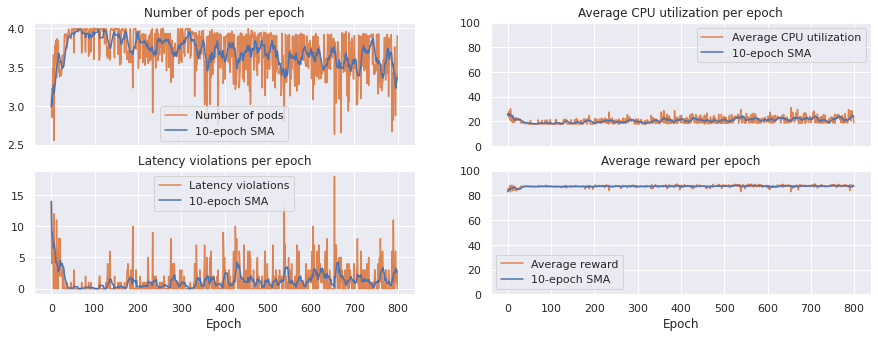

In [14]:
plot_data(epoch_data_mean, epoch_data_sum, sma_10=True)

### Only first 100 epochs

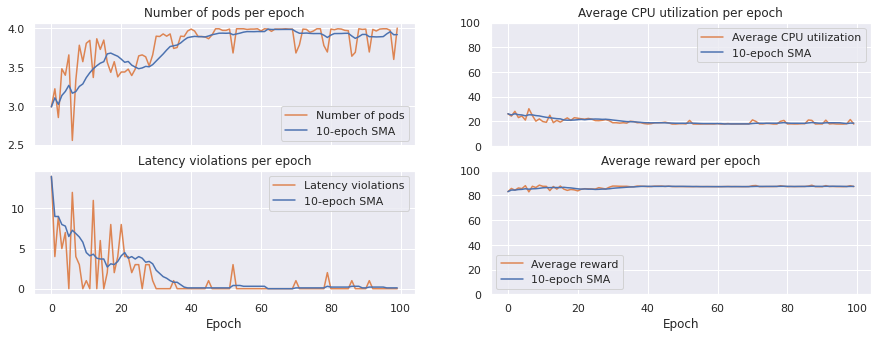

In [15]:
plot_data(epoch_data_mean[:100], epoch_data_sum[:100], sma_10=True)